# Tissue Classification using Texture Features
In this notebook, we will begin our exploration of image classification. For this example problem, we will be using an example set of [histological sample images](https://en.wikipedia.org/wiki/Histology) taken as part of a study on colorectal cancer. The full dataset and a description of its properties can be accessed at this site: http://dx.doi.org/10.5281/zenodo.53169

![Example histological images for classes a through f](https://raw.githubusercontent.com/BeaverWorksMedlytics2020/Data_Public/master/Images/Week3/Representative-images-the-first-10-images-of-every-tissue-class.png?token=ADGRCSE2YIYWUNCJTHNB5XK67T4HE)

In the above figure, we can see examples of eight different classes present in the dataset. Each row, labeled "a" through "h", corresponds to a unique class of tissue. Each of the images in a given row represents a single example image of that class of tisue. The objective of the code in this notebook is to use the [k-means algorithm](https://en.wikipedia.org/wiki/K-means_clustering) to group images from the dataset into these respective classes.

# Imports
As per usual, we will start by importing the packages and modules we will be needing for this project. In this case, we will import the usual Numpy and Matplotlib modules. We will also import some statistics modules from Scipy, and a number of utilities from the [scikit-learn](https://scikit-learn.org/stable/) and [scikit-image](https://scikit-image.org/) packages.

In [ ]:
!pip install scikit-image

     |████████████████████████████████| 29.2 MB 25.0 MB/s 
     |████████████████████████████████| 169 kB 109.1 MB/s 
     |████████████████████████████████| 3.3 MB 106.7 MB/s 
     |████████████████████████████████| 1.6 MB 101.2 MB/s 
     |████████████████████████████████| 4.4 MB 101.4 MB/s 
  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.9
    Not uninstalling decorator at /shared-libs/python3.7/py-core/lib/python3.7/site-packages, outside environment /root/venv
    Can't uninstall 'decorator'. No files were found to uninstall.
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.


In [ ]:
# Basic operating system (os), numerical, and plotting functionality
import os
import numpy as np
import matplotlib.pyplot as plt

# scipy statistics functions
from scipy.stats import mode
from scipy.stats import moment

# scikit-learn data utilities
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Color transformations
from skimage.color import rgb2lab

# Feature extractors and classification algorithm
from skimage.feature import greycomatrix, greycoprops
from skimage.feature import local_binary_pattern
from sklearn.cluster import KMeans

# scikit-learn performance metric utilities
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
# Set plotting preferences
import matplotlib
%matplotlib inline
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}
matplotlib.rc('font', **font)

# Retrieve and Load the Data
The following cell checks if the histological images have already been downloaded into the current Colab session and downloads them if not.

In [ ]:
# Define the current directory and the directory where the files to download can
# be found
current_dir = os.getcwd()
remote_path = 'https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/NotebookExampleData/Week3/data_nuclei/crc/'

# Define and build a directory to save this data in
data_dir = os.path.join(current_dir, 'crc_data')
if not os.path.isdir(data_dir):
  os.mkdir(data_dir)

# Move into the data directory and download all of the files
os.chdir(data_dir)
for ii in range(1, 6):
    basename = f'rgb0{ii}.npz'
    filename = os.path.join(remote_path, basename)

    # Check if the file has already been downloaded
    if not os.path.isfile(basename):
      cmd = f'wget {filename}'
      print(cmd)
      os.system(cmd)

# Return to the original directory
os.chdir(current_dir)

The downloaded ".npz" archives can now be read into memory and parsed. The ".npz" arhcives contain three entries.

* The "rgb_data" entry contains the image data stored as a (1000, 150, 150, 3)
    * These axes correspond to (image number, y-pixel , x-pixel, RGB color channel)
* The "labels" entry contains the numerical representation of the class associated with each of the images (value 0-7)
* "labels_str" entry contains a single dictionary which maps the numerical "label" value into a string representation. This entry is only present in the "rgb01.npz" archive.
    * 0: '02_STROMA'
    * 1: '06_MUCOSA'
    * 2: '05_DEBRIS'
    * 3: '01_TUMOR'
    * 4: '03_COMPLEX'
    * 5: '08_EMPTY'
    * 6: '04_LYMPHO'
    * 7: '07_ADIPOSE'

The cell below loops through each of the five archive files and concatenates the data in them. Additionally, only the red color channel is retained so that the final variables have the shapes

"images" shape = (5000, 150, 150)

"label_str" shape = (5000,)

Next, we define a function to use for loading the downloaded data into memory. This function also contains some lines to convert from the red-green-blue (r,g,b,) colorspace (which is the standard way to represent digital images in computers) to other colorspaces. The first colorspace is 'grayscale', which we compute by simply taking the arithmetic *average* of the (r, g, b) values. The other alternative colorspace is [CIE L\*a\*b\*](https://en.wikipedia.org/wiki/CIELAB_color_space). This can be done with the "rgb2lab" function we imported at the top of this notebook.

In [ ]:
# Define a function to load the data from the assumed download path
def load_images(colorspace='rgb'):
    """
    Loads the example data and applies transformation into requested colorspace

    Arguments
    ---------
    colorspace : str, optional, default: `rgb`
        The colorspace into which the images should be transformed. Accepted
        values include

        'rgb' : Standard red-green-blue color-space for digital images

        'gray' or 'grey': An arithmetic average of the (r, g, b) values

        'lab': The CIE L*a*b* colorspace
    
    Returns
    -------
    images : numpy.ndarray, shape (Nimg, Ny, Nx, Ncolor)
        The complete set of transformed images

    labels : numpy.ndarray, shape (Nimg)
        The classification labels associated with each entry in `images`

    label_to_str : dict
        A dictionary which converts the numerical classification value in
        `labels` into its string equivalent representation.
    """
    # Check that the colorspace argument is recognized
    colorspace_lower = colorspace.lower()
    if colorspace_lower not in ['rgb', 'gray', 'grey', 'lab']:
        raise ValueError(f'`colorspace` value of {colorspace} not recognized')

    # Load data, which is stored as a numpy archive file (.npz)
    filename = os.path.join(data_dir, 'rgb01.npz')
    print(f'loading {filename}')
    tmp = np.load(os.path.join(data_dir, 'rgb01.npz'), allow_pickle=True)

    # Parse the loaded data into images and labels
    # Initialize the images and labels variables using the first archive data
    images = tmp['rgb_data']
    if colorspace_lower == 'rgb':
        pass
    elif colorspace_lower in ['gray', 'grey']:
        images = np.mean(images, axis=-1)      # Average into grayscale
    elif colorspace_lower == 'lab':
        images = rgb2lab(images)               # Convert to CIE L*a*b*

    # Grab the initial array for the image labels
    labels = tmp['labels']
    
    # Grab the dictionary to convert numerical labels to their string equivalent
    label_to_str = tmp['label_str']
    label_to_str = label_to_str.tolist() # Convert label_to_str into a dict

    # Update the user on the number and size of images loaded
    print('Loaded images with shape {}'.format(images.shape))
    del tmp

    # Loop over each of the remaining archives and append the contained data
    for ii in range(2,6):
        # Build the full path to the archive and load it into memory
        filename = os.path.join(data_dir, f'rgb0{ii}.npz')
        print(f'loading {filename}')
        tmp = np.load(filename, allow_pickle=True)

        # Parse and append the data
        these_images = tmp['rgb_data']
        if colorspace_lower == 'rgb':
            pass
        elif (colorspace_lower == 'gray') or (colorspace_lower == 'grey'):
            these_images = np.mean(these_images, axis=-1) # Convert to grayscale
        elif colorspace_lower == 'lab':
            these_images = rgb2lab(these_images)          # Convert to CIEL*a*b*

        # Append the images and labels
        images = np.append(images, these_images, axis=0)
        labels = np.append(labels, tmp['labels'], axis=0)

        # Update the user on the number and size of images
        print('Loaded images with shape {}'.format(these_images.shape))
        del tmp

    # Force the image data to be floating point and print the data shape
    images = images.astype(np.float)
    print('Final image data shape: {}'.format(images.shape))
    print('Number of image labels: {}'.format(*labels.shape))

    return images, labels, label_to_str

With this data-loading function defined, let's load in the grayscale images.

In [ ]:
# Load the data using our data-loading function
images_gray, labels, label_to_str = load_images(colorspace='gray')

loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb01.npz
Loaded images with shape (1000, 150, 150)
loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb02.npz
Loaded images with shape (1000, 150, 150)
loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb03.npz
Loaded images with shape (1000, 150, 150)
loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb04.npz
Loaded images with shape (1000, 150, 150)
loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb05.npz
Loaded images with shape (1000, 150, 150)
Final image data shape: (5000, 150, 150)
Number of image labels: 5000


As a sanity check, we pause here to examine the first image in the dataset.

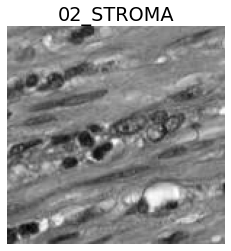

In [ ]:
# Show a sample image with its classification
ex_img_num = 1
plt.imshow(images_gray[ex_img_num], cmap='gray')
plt.title(label_to_str[labels[ex_img_num]])
plt.axis('off')
plt.show()

# Generating Image Features
Next, we experiment with some possible features to  be used for classification.

## Pixel grayscale values
As a first approach, we are going to try using the raw, grayscale image pixel values as input features in a k-means clustering algorithm and see how well it performs. To do this, we will need to flatten each of the 150x150 pixel images into a vector of length 22500. Thus, the information in each image will be represented by a single vector in a 22500 dimensional "image space."

In [ ]:
# Flatten the images into a list of vectors
num_images, nrows, ncols = images_gray.shape
images_gray = images_gray.reshape((num_images, nrows*ncols))
print('{} images flattened into vectors of length {}'.format(*images_gray.shape))

5000 images flattened into vectors of length 22500


We can use the scikit-learn "train_test_split" function to randomly divide the images and labels into training and testing sets. The fraction of the data reserved as a test set is determined by the "
test_size" keyword argument of the "train_test_split" function. For this example, we are reserving 25% of the images and associated labels as a test set.

In [ ]:
# Split the data into training and testing data
# NOTE: using convention of "X" as data and "y" as label
X_train_gray, X_test_gray, y_train, y_test = train_test_split(images_gray, labels, test_size=0.25)

# Start by clearing out the old, grayscale representation of the data
del images_gray

Next, we build a KMeans clustering estimator with eight clusters (corresponding to the eight image classes) and pass the training image vectors through the "fit()" method. This method loops through the k-means iterations group the images non-overlaping clusters in the 22500 dimensional image space. This training method attempts to divide the input images into eight non-overlaping clusters. However, it is important to note that the training labels were not fed into the "fit()" method, so the result of the kmeans algorithm does not immediately inform the user what . Instead, it only identifies eight groupings of images and assigns them an effective "cluster number."

In [ ]:
# Run the KMeans clustering algorithm
kmeans_estimator = KMeans(n_clusters=8, max_iter=10).fit(X_train_gray)

Next, predict a cluster number for each of the test images based on the clustering boundaries estimated from the training images.

In [ ]:
# Predict which cluster each of the test images lives in of the test images
preds = kmeans_estimator.predict(X_test_gray)

Although we now have the predicted cluster number for each of the test images, we need to convert those into actual classification values.

In [ ]:
# Assign Class prediction to match IDs
pred_labels = np.zeros_like(preds)
mask = pred_labels.copy().astype(bool)

# Loop over each cluster
for icluster in range(8):
    # Build a mask indicating which test images have this cluster number
    mask = (preds == icluster)

    # Grab the *most common* label associated with these test images
    pred_labels[mask] = mode(y_test[mask]).mode[0]

With our final classification predictions in hand, we can proceed to compare the predictions to the *correct* answers stored in the "y_test_gray" variable. As a first step, we'll examine the true and predicted labels associated with a sample set of test images.

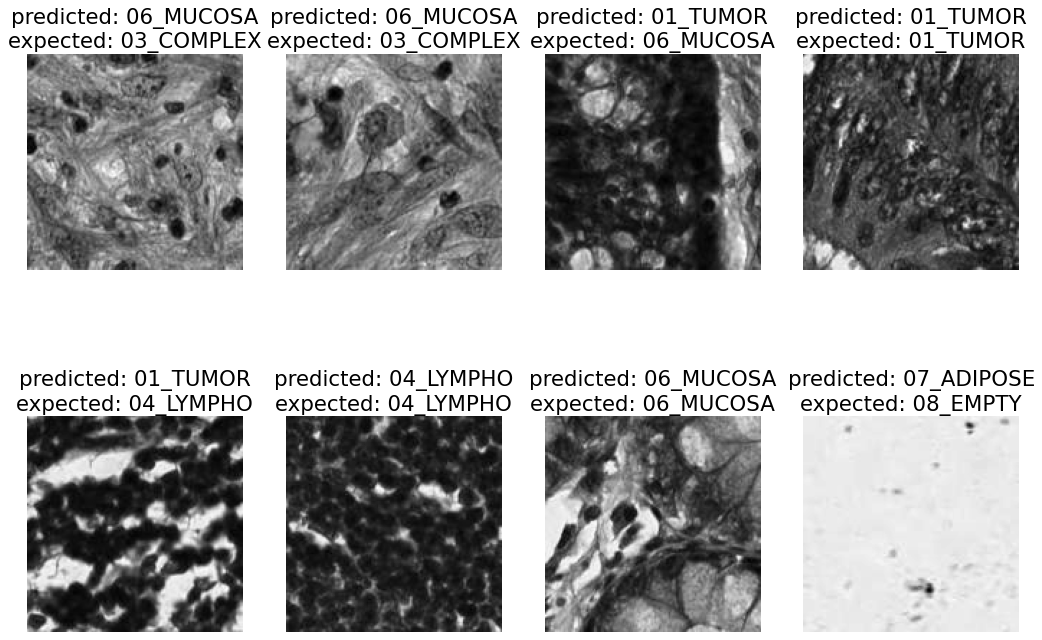

In [ ]:
# Reshape the image data back into a 2D format
num_test = len(y_test)
images_test_gray = X_test_gray.reshape((num_test, nrows, ncols))

# Generate some random samples
np.random.seed(123456789)
sample_inds = np.random.choice(num_test, 8, replace=False)

# Generate a figure
plt.figure(figsize=(16, 11), dpi= 80)

# Loop over eight images, display them and show their labels
for ii, ind in enumerate(sample_inds):
    plt.subplot(2,4,ii+1)
    plt.imshow(np.round(images_test_gray[ind]).astype(int), cmap='gray')
    title_str = ('predicted: ' + label_to_str[pred_labels[ind]] + '\n' +
                 'expected: ' + label_to_str[y_test[ind]])
    plt.title(title_str)
    plt.axis('off')

plt.show()

As a single, summarry statistic, let's compute the total accuracy of this classifier. This can be done using the "accuracy_score" function imported at the beginning of this notebook.

In [ ]:
# Calculate accurate = (correctly labeled images /  number of images)
acc_gray = accuracy_score(y_test, pred_labels)
print('k-means clustering on raw grayscale pixel values...')
print(f'Total accuracy: {acc_gray:4.1%}')

k-means clustering on raw grayscale pixel values...
Total accuracy: 45.2%


Unless the random number generators behind the k-means algorithm were extremely kind to you, the total accuracy of this algorithm probably does not look very promising at this point. Nevertheless, lets see if we can find a different set of features that may work better with the k-means algorithm.

## Pixel color values
We averaged the RGB channel values when loading the dataset above to get a set of grayscale images. That averaging procedure threw away a lot of information, and that information may be helpful in classifying these images. For example, you may notice some color related patterns in the example histological images at the top of this notebook. The images for class "a" are rather red while the images for classes "g" and "h" have very little red color in them.

Next, we will try re-running the k-means algorithm, but this time we will keep all of the RGB channels.

In [ ]:
# Clear out all of the old copies of the data for memory management
del X_train_gray, X_test_gray, y_train, y_test, images_test_gray

# Load the data using our data-loading function
images_lab, labels, label_to_str = load_images(colorspace='lab')

loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb01.npz
Loaded images with shape (1000, 150, 150, 3)
loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb02.npz
Loaded images with shape (1000, 150, 150, 3)
loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb03.npz
Loaded images with shape (1000, 150, 150, 3)
loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb04.npz
Loaded images with shape (1000, 150, 150, 3)
loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb05.npz
Loaded images with shape (1000, 150, 150, 3)
Final image data shape: (5000, 150, 150, 3)
Number of image labels: 5000


Now that we have loaded these images and converted them into L* a* b* space, we can really focus in on the *color* information. To do that, we are going to *discard* the brightness information, which is fairly well isolated in the L* component of the images.

In [ ]:
# Taking out the L* channel, leaving only a* and b* channels
images_ab = images_lab[:,:,:,1:3]
del images_lab

We again need to flatten these images into vectors, and the code in this cell does that for us.

In [ ]:
# Flattening the images into vectors
num_images, nrows, ncols, ndims = images_ab.shape
images_ab = images_ab.reshape((num_images, nrows*ncols*ndims))
print('{} images flattened into vectors of length {}'.format(*images_ab.shape))

5000 images flattened into vectors of length 45000


We will again split this data into training and test sets.

In [ ]:
# Split the data into training and testing sets
# NOTE: using convention of "X" as data and "y" as label
tmp = train_test_split(np.arange(num_images), images_ab, labels, test_size=0.25)
inds_train, inds_test, X_train_ab, X_test_ab, y_train, y_test = tmp

# We no longer need a copy of the "images_ab" or "tmp" variables
del images_ab
del tmp

Now repeat the k-means clusterin algorithm using the data from the a* and b* color channels of the images.

In [ ]:
# Cluster the images using the KMeans algorithm
kmeans_estimator = KMeans(n_clusters=8, max_iter=10).fit(X_train_ab)

Predict which cluster each of the test images is associated with.

In [ ]:
# Make predictions for the test images based on the clustering
preds = kmeans_estimator.predict(X_test_ab)

In [ ]:
# Assign Class prediction to match IDs
pred_labels = np.zeros_like(preds)
mask = pred_labels.astype(bool)

# Loop over each cluster
for icluster in range(8):
    # Build a mask indicating which test images have this cluster number
    mask = (preds == icluster)

    # Grab the *most common* label associated with these test images
    pred_labels[mask] = mode(y_test[mask]).mode[0]

With our final classification predictions in hand, we can proceed to compare the predictions to the *correct* answers stored in the "y_test" variable. As a first step, we'll examine the true and predicted labels associated with a sample set of test images.

loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb01.npz
Loaded images with shape (1000, 150, 150, 3)
loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb02.npz
Loaded images with shape (1000, 150, 150, 3)
loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb03.npz
Loaded images with shape (1000, 150, 150, 3)
loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb04.npz
Loaded images with shape (1000, 150, 150, 3)
loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb05.npz
Loaded images with shape (1000, 150, 150, 3)
Final image data shape: (5000, 150, 150, 3)
Number of image labels: 5000


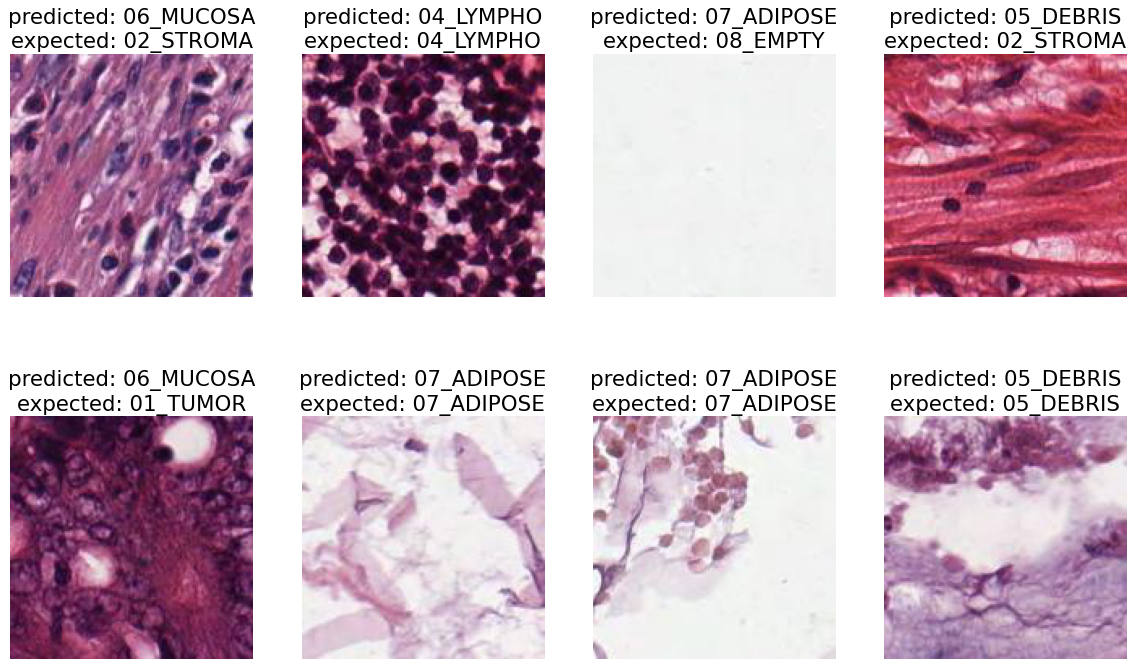

In [ ]:
# Load the RGB versions of the images
images_rgb, _, _ = load_images(colorspace='rgb')

# Generate some random samples
num_test = len(y_test)
np.random.seed(123456789)
sample_inds = np.random.choice(num_test, 8, replace=False)

# Generate a figure
plt.figure(figsize=(18, 11), dpi= 80)

# Loop over eight images, display them and show their labels
for ii, ind  in enumerate(sample_inds):
    plt.subplot(2,4,ii+1)
    plt.imshow(np.round(images_rgb[inds_test[ind]]).astype(int))
    title_str = ('predicted: ' + label_to_str[pred_labels[ind]] + '\n' +
                 'expected: ' + label_to_str[y_test[ind]])
    plt.title(title_str)
    plt.axis('off')

plt.show()

As a summary statistic, we compute the total accuracy of the k-means clustering algorithm on the a* and b* color channels.

In [ ]:
# Calculate Accuracy
acc = accuracy_score(y_test, pred_labels)
print('KMeans clustering on raw a* and b* pixel values...')
print(f'Total accuracy: {acc:4.1%}')

KMeans clustering on raw a* and b* pixel values...
Total accuracy: 40.6%


It seems that our intuation may have been a bit misguieded, as it does not appear to be the case that using the a* and b* color information significantly improved the classification accuracy. In fact, it seems to have reduced the classification accuracy!

In general, it seems that using raw image data as a feature set is not a particularly great way to classify images. In the next section, we will consider how we might generate some more thoughtfully engineered features for image classification.

## The Co-occurrence Matrix
One option for extracting features from an image is to use the gray-level co-occurance matrix. This matrix captures information about the relationships between pixel brightnesses (gray-level) and pixel offsets and is a common tool for extracting information about texture in an image. For an $n \times m$ image $I$ and a pre-specified offset $(\Delta x, \Delta y)$, the co-occurance matrix $P_{i,j}$ is defined as the number of times that gray-level $j$ occurs at an offset $(\Delta x, \Delta y)$ from gray-level $i$. For the equation, see https://en.wikipedia.org/wiki/Co-occurrence_matrix. 

<!-- $$P_{i,j} = \sum_{x=1}^{n} \sum_{y=1}^{m}
\begin{cases}
    1, & \text{if $\quad I(x, y) = i \quad$ and $\quad I(x + \Delta x, y + \Delta y) = j$} \\
    0, & \text{otherwise}
\end{cases}$$ -->

Notes on the equation: In the article, the Co-occurence matrix is referred to as $C_{i,j}$, but we will generally call it $P_{i,j}$. $i$ and $j$ can be any value from $0$ up to the maximum pixel value in the image. Thus, $P_{i,j}$ is a square matrix with shape ($n_{\rm level} \times n_{\rm level}$).

Notice how this matrix is defined for a particular pixel offset  $(\Delta x, \Delta y)$. Thus, we can compute several co-occurance matrices corresponding to different pixel offsets. Each of these matrices will capture information about the texture of an image at particular scales and directions. An example co-occurence matrix for an offset ($\Delta x = 1, \Delta y = 0$) is given below.

![Example co-occurrence matrix](https://github.com/BeaverWorksMedlytics2020/Data_Public/raw/master/Images/Week3/co-occurrence-matrix_full.png)


With the co-occurance matrices computed, we can extract several features from them. For reference, the features computed from the co-occurance matrix ($P_{i,j}$) are

* contrast: $\sum_{i,j=0}^{n_{\rm level} - 1} P_{i,j} \times (i-j)^2$

* dissimilarity: $\sum_{i,j=0}^{n_{\rm level} - 1} P_{i,j} \times \left|i-j\right|$

* homogeneity: $\sum_{i,j=0}^{n_{\rm level} - 1} \frac{P_{i,j}}{1+(x-j)^2}$

* ASM: $\sum_{i,j=0}^{n_{\rm level} - 1} P_{i,j}^2$

* energy: $\sqrt{\rm ASM}$

* correlation: $\sum_{i,j=0}^{n_{\rm level} - 1} P_{i,j} 
\times \left[
    \frac{(i - \mu_i) (j - \mu_j)}
    {\sqrt{(\sigma_i^2 \sigma_j^2}}
\right]$,

where $\mu$ and $\sigma$ are the weighted average and standard deviaton of $i$ and $j$ values in the $P_{i,j}$ matrix.

In [ ]:
# Begin by clearing out all the old data if that has not yet been done
try:
    del X_train_ab, X_test_ab, y_train, y_test
except:
    pass
try:
    del images_rgb
except:
    pass

# Now reload the grayscale images
images_gray, labels, label_to_str = load_images(colorspace='gray')
num_images = len(labels)

loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb01.npz
Loaded images with shape (1000, 150, 150)
loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb02.npz
Loaded images with shape (1000, 150, 150)
loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb03.npz
Loaded images with shape (1000, 150, 150)
loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb04.npz
Loaded images with shape (1000, 150, 150)
loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb05.npz
Loaded images with shape (1000, 150, 150)
Final image data shape: (5000, 150, 150)
Number of image labels: 5000


In [ ]:
# Initialize an array in which to store the image features
comatrix_features = np.array([])

# Loop over each image in the training set
for k in range(num_images):
  # Compute the grey-lever co-occurence matrix for this image
  # NOTE: For some reason the scikit-image.greycomatrix function specifies pixel
  # offsets in terms of distance and angles. Here we use a distance of 1 pixel
  # and angular offsets of 0 and pi/2 to specify the offsets (dx = 1, dy = 0)
  # and (dx = 0, dy = 1).
  comatrix = greycomatrix(images_gray[k].astype('int'), distances=[1],
                        angles=[0, np.pi/2], levels = 256)
  comatrix_features = np.append(comatrix_features, greycoprops(comatrix, 'contrast'))
  comatrix_features = np.append(comatrix_features, greycoprops(comatrix, 'dissimilarity'))
  comatrix_features = np.append(comatrix_features, greycoprops(comatrix, 'homogeneity'))
  comatrix_features = np.append(comatrix_features, greycoprops(comatrix, 'energy'))
  comatrix_features = np.append(comatrix_features, greycoprops(comatrix, 'correlation'))
  comatrix_features = np.append(comatrix_features, greycoprops(comatrix, 'ASM'))

# Reshape the array of features so that first axis is the image index and second
# axis is the feature index.
comatrix_features = comatrix_features.reshape(num_images, 12)

In [ ]:
# Split the data into training and testing sets
# NOTE: using convention of "X" as data/features and "y" as label
tmp = train_test_split(np.arange(num_images), comatrix_features, labels, test_size=0.25)
inds_train, inds_test, X_train_comatrix, X_test_comatrix, y_train, y_test = tmp

With those features extracted from the co-occurence matrices for each of the training and test images, we proceed to apply k-means clustering to these features.

In [ ]:
# Cluster the images using the KMeans algorithm
kmeans_estimator = KMeans(n_clusters=8, max_iter=10).fit(X_train_comatrix)

Predict which cluster each of the test images is associated with.

In [ ]:
# Make predictions for the test images based on the clustering
preds = kmeans_estimator.predict(X_test_comatrix)

In [ ]:
# Assign Class prediction to match IDs
pred_labels = np.zeros_like(preds)
mask = pred_labels.astype(bool)

# Loop over each cluster
for icluster in range(8):
    # Build a mask indicating which test images have this cluster number
    mask = (preds == icluster)

    # Grab the *most common* label associated with these test images
    pred_labels[mask] = mode(y_test[mask]).mode[0]

With our final classification predictions in hand, we can proceed to compare the predictions to the *correct* answers stored in the "y_test" variable. As a first step, we'll examine the true and predicted labels associated with a sample set of test images.

loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb01.npz
Loaded images with shape (1000, 150, 150, 3)
loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb02.npz
Loaded images with shape (1000, 150, 150, 3)
loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb03.npz
Loaded images with shape (1000, 150, 150, 3)
loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb04.npz
Loaded images with shape (1000, 150, 150, 3)
loading /work/Notebooks/01_ImageFetauresAndKmeansClustering/crc_data/rgb05.npz
Loaded images with shape (1000, 150, 150, 3)
Final image data shape: (5000, 150, 150, 3)
Number of image labels: 5000


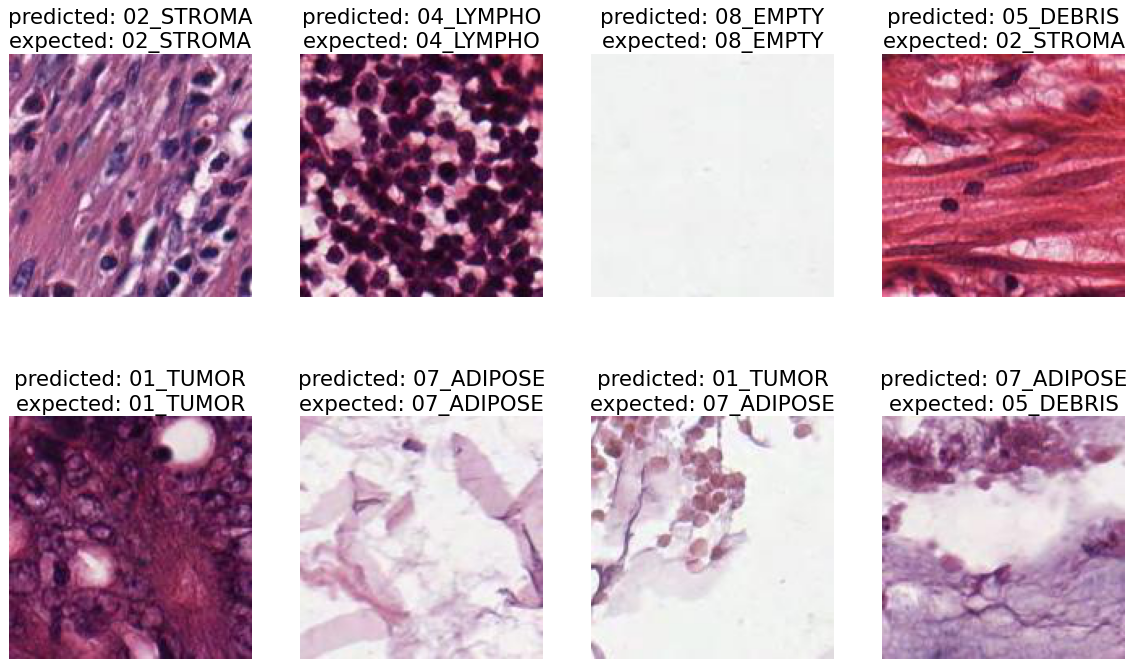

In [ ]:
# Load the RGB versions of the images
images_rgb, _, _ = load_images(colorspace='rgb')

# Generate some random samples
num_test = len(y_test)
np.random.seed(123456789)
sample_inds = np.random.choice(num_test, 8, replace=False)

# Generate a figure
plt.figure(figsize=(18, 11), dpi= 80)

# Loop over eight images, display them and show their labels
for ii, ind  in enumerate(sample_inds):
    plt.subplot(2,4,ii+1)
    plt.imshow(np.round(images_rgb[inds_test[ind]]).astype(int))
    title_str = ('predicted: ' + label_to_str[pred_labels[ind]] + '\n' +
                 'expected: ' + label_to_str[y_test[ind]])
    plt.title(title_str)
    plt.axis('off')

plt.show()

As a summary statistic, we compute the total accuracy of the k-means clustering algorithm on the gray-level co-occurence matrix features.

In [ ]:
# Get the accuracy and confusion matrix
acc = accuracy_score(y_test, pred_labels)
mat = confusion_matrix(y_test, pred_labels)
print(acc)
print(mat)

0.348
[[ 18  15  20  20   0  19  10  32]
 [  0  66  14  60   0   0  12  12]
 [  2  32  23  46   0   1   4  39]
 [  0  36   2  67   0   5   8  46]
 [  8  62  19  32   0   0  25  14]
 [  0   0   0   0   0 144   0   0]
 [ 17  49  11  22   0   0  69   7]
 [  0   0   1   6   0 107   0  48]]


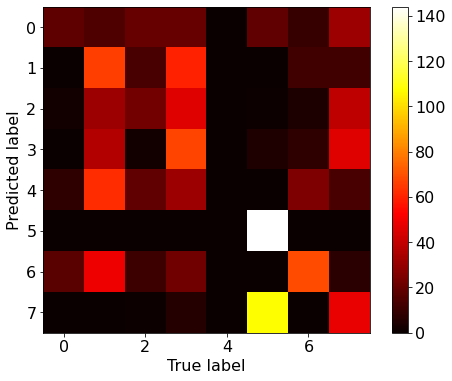

In [ ]:
# Also visualize the confusion matrix
plt.figure(figsize=(8,6))
plt.imshow(mat, cmap='hot', interpolation='nearest')
plt.grid(False)
plt.colorbar()
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=8ceab382-16c2-4c1c-bf27-39206ff9a894' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>